# Two-body correlations

In [22]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
using LaTeXStrings;

## Finite T

### MPBP

In [32]:
T = 18         # final time
k = 3          # degree
m⁰ = 0.3       # magnetization at time zero

β = 1.0
J = 0.3
h = 0.2;

In [33]:
m_eq, r_eq = equilibrium_observables(RandomRegular(k), J; β, h);

In [34]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp);

In [35]:
matrix_sizes = [5, 10, 15]
maxiters = fill(50, length(matrix_sizes))
iters = zeros(Int, length(maxiters))
tol = 1e-5
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
end

Running MPBP: iter 31    Time: 0:06:50
  Δ:      7.020585632844245e-6


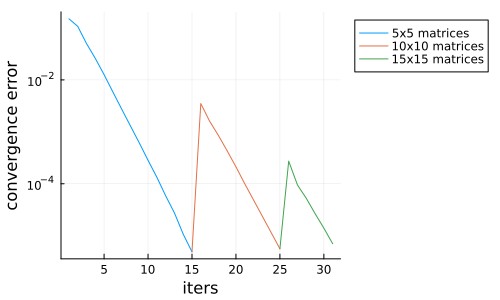

In [41]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

In [66]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)

pb = pair_beliefs_as_mpem(bp)[1][1]
tv = twovar_marginals(pb)

corrs_alternate = map(1:T) do t
    tvt = tv[t,t+1]
    joint1 = dropdims(sum(tvt; dims=(2,3)); dims=(2,3))
    joint2 = dropdims(sum(tvt; dims=(1,4)); dims=(1,4))
    @assert joint1 ≈ joint2
    expectation(spin, joint1)
end;

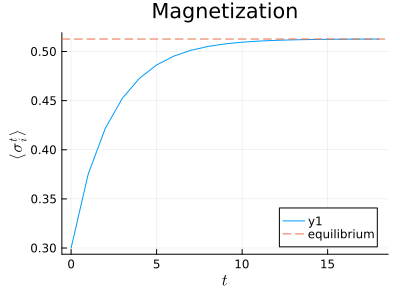

In [44]:
m_bp = means(spin, bp)
pl_m = plot(0:T, m_bp; title="Magnetization", xlabel=L"t", ylabel=L"\langle \sigma_i^t \rangle")
hline!(pl_m, [m_eq], ls=:dash, label="equilibrium", size=(400,300))

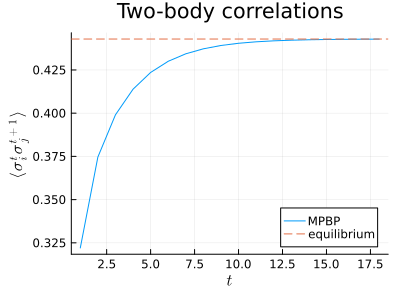

In [67]:
pl_c = plot(; title="Two-body correlations", xlabel=L"t", 
    ylabel=L"\langle \sigma_i^t \sigma_j^{t+1} \rangle")
plot!(pl_c, corrs_alternate, label="MPBP")
hline!(pl_c, [r_eq], ls=:dash, label="equilibrium", size=(400,300))

### Monte Carlo

In [42]:
using Graphs, IndexedGraphs, Statistics

N = 5*10^3
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp_mc = mpbp(Glauber(ising, T); ϕ = fill(ϕᵢ, N))
sms = SoftMarginSampler(bp_mc);

In [43]:
sample!(sms, 10^3)
spin(x) = 3-2x
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:56


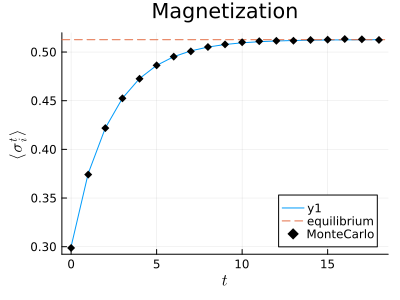

In [47]:
plot!(deepcopy(pl_m),0:T, mean(m_mc), st=:scatter, m=:diamond, c=:black, label="MonteCarlo")

In [61]:
import StatsBase, UnPack
function pair_marginals_ttp1(sms::SoftMarginSampler; showprogress::Bool=true) 
    UnPack.@unpack bp, X, w = sms
    g = bp.g
    T = length(bp.ϕ[1])-1; E = ne(g)
    marg = [[zeros(nstates(bp,i), nstates(bp,j)) for t in 1:T] for (i,j,id) in edges(g)]
    @assert all(>=(0), w)
    wv = StatsBase.weights(w)
    nsamples = length(X)
    prog = ProgressMeter.Progress(E, desc="Marginals from Soft Margin"; dt=showprogress ? 0.1 : Inf)
    x = zeros(Int, length(X))

    for (i,j,id) in edges(g)
        linear = LinearIndices((1:nstates(bp,i), 1:nstates(bp,j)))
        for t in 1:T
            x .= [linear[xx[i, t],xx[j,t+1]] for xx in X]
            mijt_avg_linear = StatsBase.proportions(x, nstates(bp,i)*nstates(bp,j), wv)
            mijt_avg = reshape(mijt_avg_linear, linear.indices...)
            # avoid numerical errors yielding probabilities > 1
            marg[id][t] .= map(x -> x≥1 ? 1 : x, mijt_avg)
        end
        ProgressMeter.next!(prog)
    end

   return marg
end

pair_marginals_ttp1 (generic function with 1 method)

In [62]:
marg_alternate = pair_marginals_ttp1(sms);

Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:58


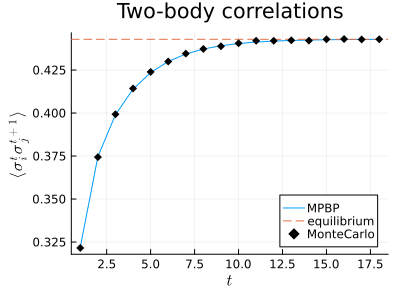

In [68]:
scatter!(deepcopy(pl_c), expectation.(spin, mean(marg_alternate)), m=:diamond, c=:black, label="MonteCarlo")